<a href="https://colab.research.google.com/github/neel26desai/cmpe258_transfer_learning_cv/blob/main/Transfer_Learning_with_BigTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 23.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [2]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

SEEDS = 42

keras.utils.set_random_seed(SEEDS)

In [3]:
from keras import ops

#Gather Flower data

In [4]:
train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True,
)

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


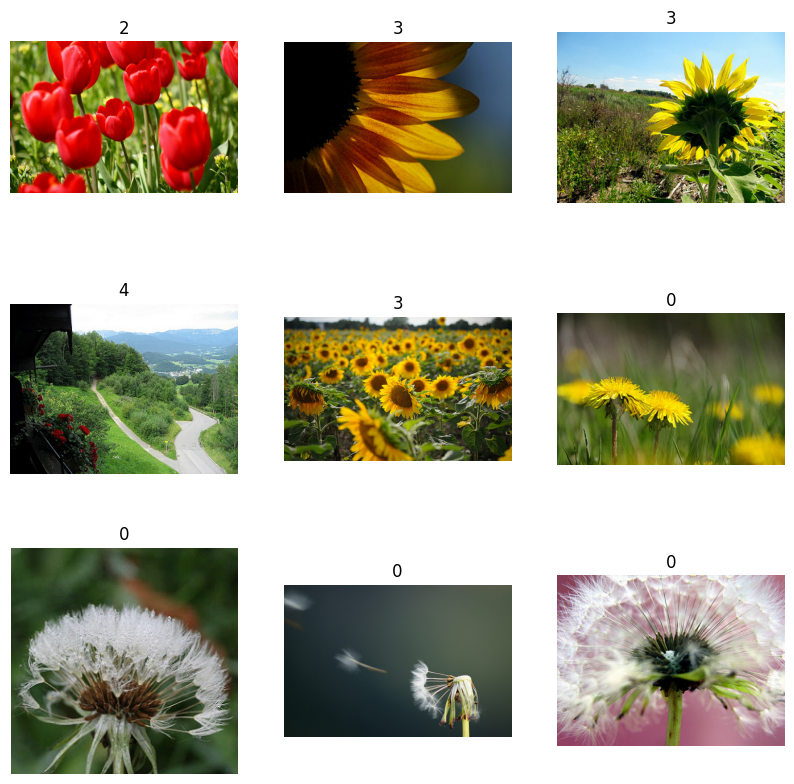

In [5]:
#some visualization
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [6]:
RESIZE_TO = 384
CROP_TO = 224
BATCH_SIZE = 64
STEPS_PER_EPOCH = 10
AUTO = tf.data.AUTOTUNE  # optimise the pipeline performance
NUM_CLASSES = 5  # number of classes
SCHEDULE_LENGTH = (
    500  # we will train on lower resolution images and will still attain good results
)
SCHEDULE_BOUNDARIES = [
    200,
    300,
    400,
]  # more the dataset size the schedule length increase

In [7]:
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE

random_flip = keras.layers.RandomFlip("horizontal")
random_crop = keras.layers.RandomCrop(CROP_TO, CROP_TO)

def preprocess_train(image, label):
    image = random_flip(image)
    image = ops.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = random_crop(image)
    image = image / 255.0
    return (image, label)


def preprocess_test(image, label):
    image = ops.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = ops.cast(image, dtype="float32")
    image = image / 255.0
    return (image, label)


DATASET_NUM_TRAIN_EXAMPLES = train_ds.cardinality().numpy()

repeat_count = int(
    SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH
)
repeat_count += 50 + 1  # To ensure at least there are 50 epochs of training

Define data pipeline

In [8]:
# Training pipeline
pipeline_train = (
    train_ds.shuffle(10000)
    .repeat(repeat_count)  # Repeat dataset_size / num_steps
    .map(preprocess_train, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Validation pipeline
pipeline_validation = (
    validation_ds.map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

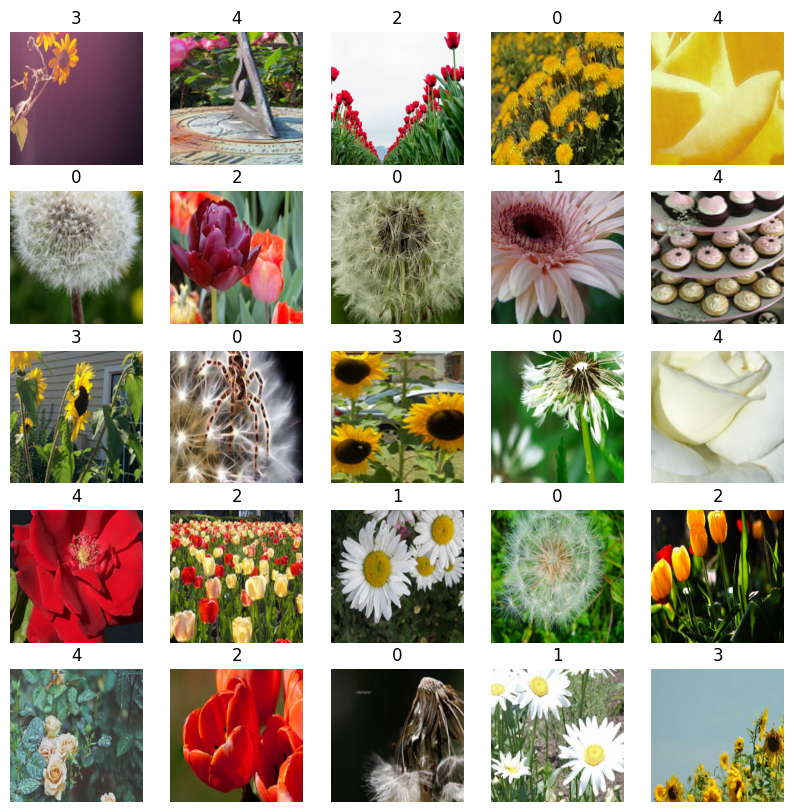

In [9]:
#visualizing the training sample
image_batch, label_batch = next(iter(pipeline_train))

plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(image_batch[n])
    plt.title(label_batch[n].numpy())
    plt.axis("off")

In [10]:
#loading the pretrained model from tensorflow hun in a keras layer
bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
bit_module = hub.load(bit_model_url)

Create a BigTransfer Model

In [11]:
class MyBiTModel(keras.Model):
    def __init__(self, num_classes, module, **kwargs):
        super().__init__(**kwargs)

        self.num_classes = num_classes
        self.head = keras.layers.Dense(num_classes, kernel_initializer="zeros")
        self.bit_model = module

    def call(self, images):
        bit_embedding = self.bit_model(images)
        return self.head(bit_embedding)


model = MyBiTModel(num_classes=NUM_CLASSES, module=bit_module)

In [12]:
model.summary()

Model: "my_bi_t_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [13]:
learning_rate = 0.003 * BATCH_SIZE / 512

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[
        learning_rate,
        learning_rate * 0.1,
        learning_rate * 0.01,
        learning_rate * 0.001,
    ],
)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [14]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

In [15]:
  train_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=2, restore_best_weights=True
    )
]

In [16]:
history = model.fit(
    pipeline_train,
    batch_size=BATCH_SIZE,
    epochs=2,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=pipeline_validation,
    callbacks=train_callbacks,
)

Epoch 1/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 393s 37s/step - accuracy: 0.6160 - loss: 1.1141 - val_accuracy: 0.9600 - val_loss: 0.1867
Epoch 2/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 285s 29s/step - accuracy: 0.9495 - loss: 0.1766 - val_accuracy: 0.9691 - val_loss: 0.1132


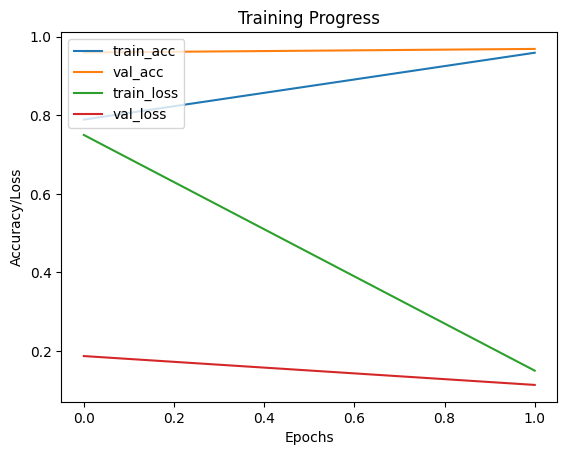

In [17]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    plt.show()


plot_hist(history)

In [18]:
accuracy = model.evaluate(pipeline_validation)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 423ms/step - accuracy: 0.9676 - loss: 0.1229
Accuracy: 96.91%


Reference:

1. https://keras.io/examples/vision/bit/